In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from sentence_transformers import SentenceTransformer, util

In [2]:
model_ST = SentenceTransformer("all-MiniLM-L6-v2")

In [3]:
def compute_cosine_similarities(df: pd.DataFrame, model_ST: SentenceTransformer) -> List[float]:
    """
    Computes cosine similarity between target queries and generated outputs.

    Args:
        df (pd.DataFrame): The DataFrame containing 'target_query' and 'generated_output' columns.
        model_ST (SentenceTransformer): Pretrained Sentence Transformer model.

    Returns:
        List[float]: A list of cosine similarity scores.
    """
    cosine_similarities = []
    
    for idx, row in df.iterrows():
        target = str(row["target_query"])
        title = str(row["title"])
        
        # Encode both target and generated text into embeddings
        embeddings = model_ST.encode([title, target], convert_to_tensor=True)
        
        # Compute cosine similarity
        cos_sim = util.cos_sim(embeddings[0], embeddings[1])
        
        # Append similarity score
        cosine_similarities.append(float(cos_sim.item()))
    
    return cosine_similarities

In [4]:
def plot_similarity_vs_rouge(filtered_df: pd.DataFrame) -> None:
    """
    Plots four scatter plots showing the relationship between semantic similarity (cosine similarity)
    and ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L, ROUGE-Lsum) in a 2x2 subplot format.

    Args:
        filtered_df (pd.DataFrame): The DataFrame containing columns 'semantic_similarity' 
                                    and ROUGE scores ('rouge1', 'rouge2', 'rougeL', 'rougeLsum').

    Returns:
        None: Displays a figure with four subplots.
    """
    # Define metrics and corresponding colors
    metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
    colors = ["blue", "red", "green", "purple"]

    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over metrics and corresponding axes
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        sns.scatterplot(
            data=filtered_df, 
            x="semantic_similarity", 
            y=metric, 
            color=color, 
            alpha=0.7, 
            ax=axes[i]
        )

        axes[i].set_title(f"Semantic Similarity vs. {metric.upper()}", fontsize=12)
        axes[i].set_xlabel("Semantic Similarity (Cosine Similarity)")
        axes[i].set_ylabel(f"{metric.upper()} Score")
        axes[i].grid(True, linestyle="--", alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the combined figure
    plt.show()

In [5]:
def plot_semantic_similarity_distribution(filtered_df: pd.DataFrame) -> None:
    """
    Plots a histogram showing the distribution of semantic similarity (cosine similarity) scores.

    Args:
        filtered_df (pd.DataFrame): The DataFrame containing the 'semantic_similarity' column.

    Returns:
        None: Displays a histogram plot.
    """
    plt.figure(figsize=(8, 5))
    
    # Histogram with KDE (Kernel Density Estimation)
    sns.histplot(filtered_df["semantic_similarity"], bins=25, kde=True, color="blue")

    # Titles and labels
    plt.title("Distribution of Semantic Similarity Scores", fontsize=14)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    # Grid for better readability
    plt.grid(True, linestyle="--", alpha=0.6)
    
    # Show the plot
    plt.show()

In [ ]:
results = pd.read_csv("filtered_results.csv")

In [7]:
results["semantic_similarity"] = compute_cosine_similarities(results, model_ST)

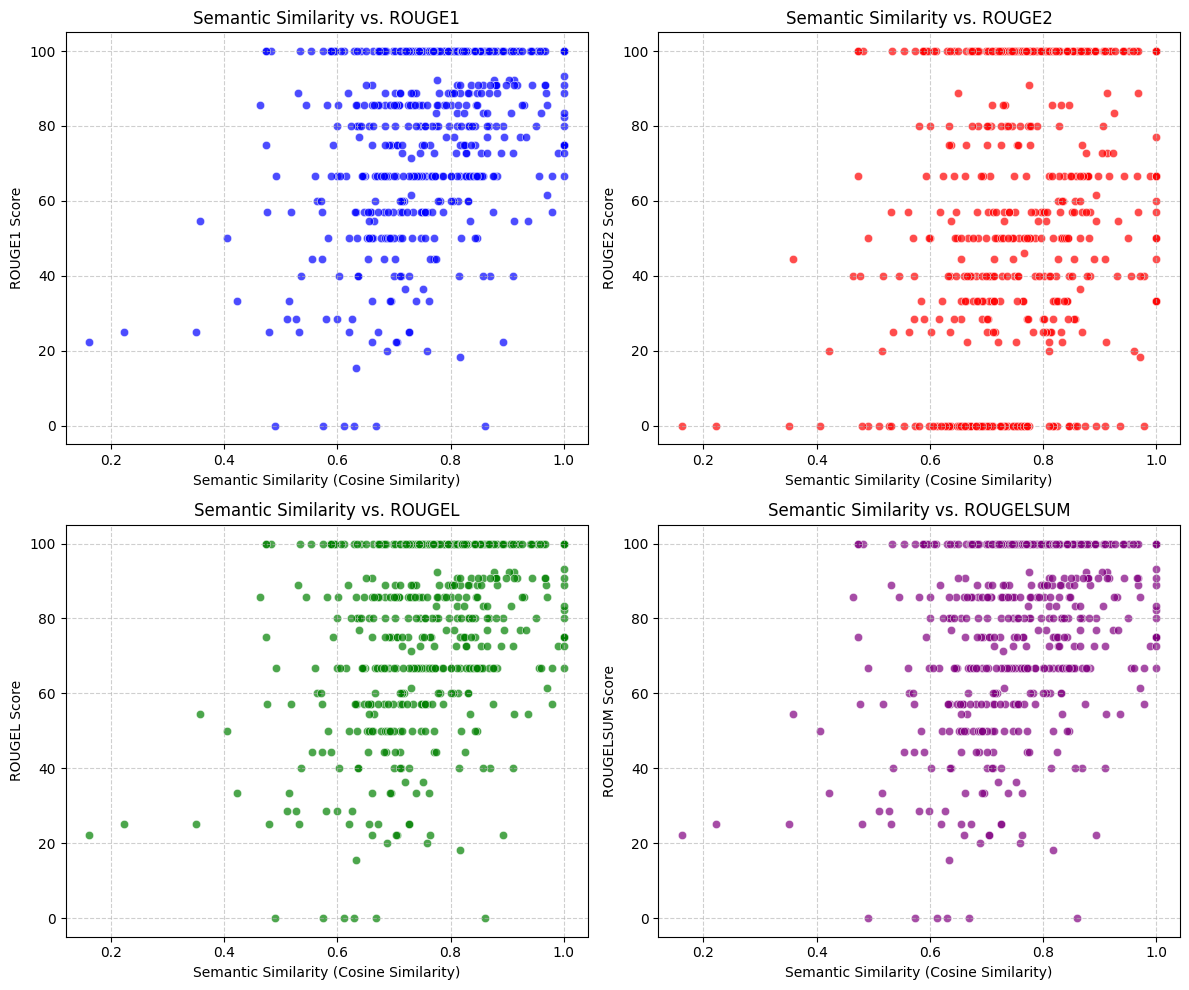

In [8]:
plot_similarity_vs_rouge(results)

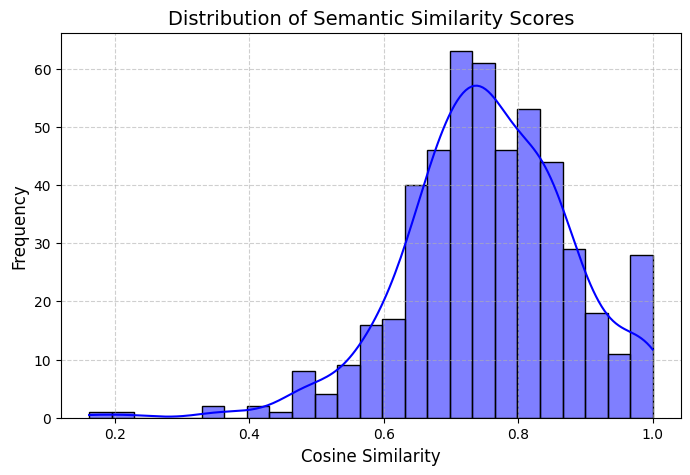

In [9]:
plot_semantic_similarity_distribution(results)

In [10]:
mean_similarity = results["semantic_similarity"].mean()
median_similarity = results["semantic_similarity"].median()
q1 = results["semantic_similarity"].quantile(0.25)  # 25th percentile
q3 = results["semantic_similarity"].quantile(0.75)  # 75th percentile

print(f"Mean Cosine Similarity: {mean_similarity:.4f}")
print(f"Median Cosine Similarity: {median_similarity:.4f}")
print(f"25th Percentile (Q1): {q1:.4f}")
print(f"75th Percentile (Q3): {q3:.4f}")

Mean Cosine Similarity: 0.7553
Median Cosine Similarity: 0.7535
25th Percentile (Q1): 0.6834
75th Percentile (Q3): 0.8365


In [24]:
results["semantic_similarity"].describe()

count    500.000000
mean       0.755291
std        0.124074
min        0.161890
25%        0.683424
50%        0.753505
75%        0.836499
max        1.000000
Name: semantic_similarity, dtype: float64

In [11]:
def plot_semantic_similarity_with_threshold(filtered_df: pd.DataFrame, threshold: float = None) -> None:
    """
    Plots a histogram showing the distribution of semantic similarity scores and an optional threshold line.

    Args:
        filtered_df (pd.DataFrame): The DataFrame containing 'semantic_similarity'.
        threshold (float, optional): The threshold value to visualize on the histogram.

    Returns:
        None: Displays a histogram plot.
    """
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_df["semantic_similarity"], bins=25, kde=True, color="blue")

    if threshold is not None:
        plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold: {threshold:.4f}")

    plt.title("Distribution of Semantic Similarity Scores", fontsize=14)
    plt.xlabel("Cosine Similarity", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


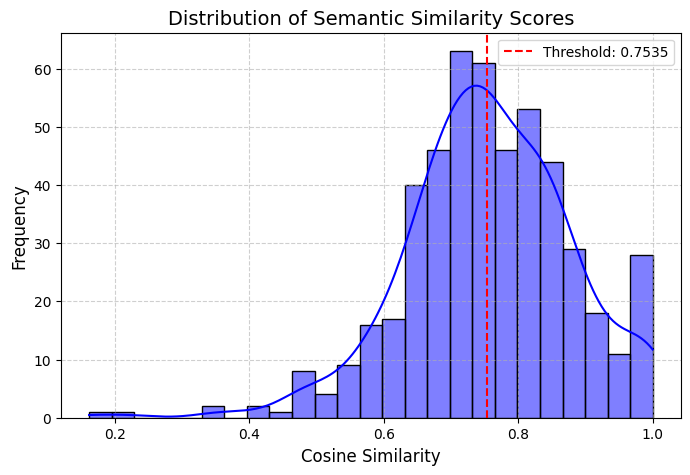

In [22]:
plot_semantic_similarity_with_threshold(results, threshold=median_similarity)


In [20]:
below_median = (results["semantic_similarity"] < 0.75).sum()
above_median = (results["semantic_similarity"] >= 0.75).sum()

print(f"Number of examples below median: {below_median}")
print(f"Number of examples above median: {above_median}")


Number of examples below median: 242
Number of examples above median: 258


## Dataset target query analysis

In [1]:
from datasets import load_dataset

dataset = load_dataset("smartcat/Amazon_Sample_Metadata_2023", name="product2query_V1", split="train")
df = pd.DataFrame(dataset)

In [2]:
queries = df["short_query"].tolist()
len(queries)

257549

In [25]:
max_len = 0
for query in queries:
    if len(query.split()) > max_len:

        max_len = len(query.split())

print(f"Longest generated query has {max_len} words.")

min_len = max_len
for query in queries:
    if len(query.split()) < min_len:
        min_len = len(query.split())
        
print(f"Shortest generated query has {min_len} words.")

Longest generated query has 12 words.
Shortest generated query has 0 words.


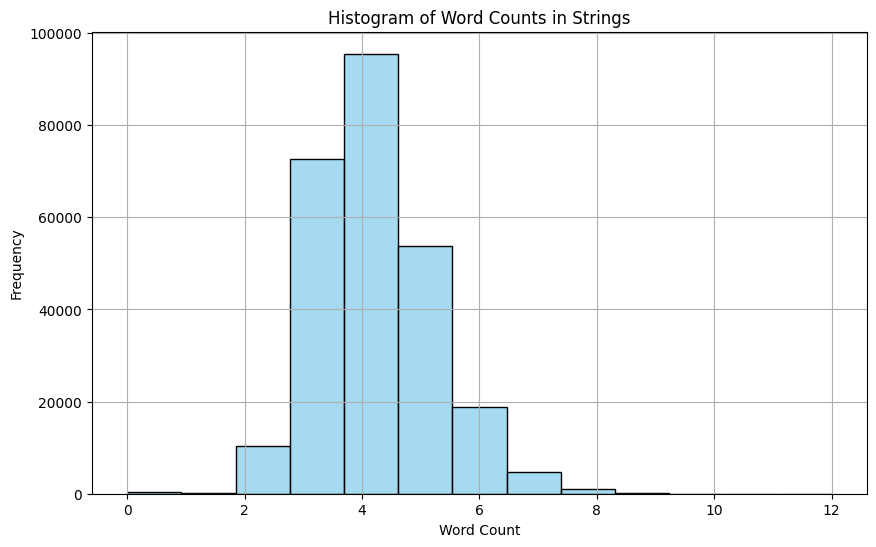

In [24]:
def display_word_count_histogram(strings: list, bins: int = 20):

    # Count the number of words in each string
    word_counts = [len(s.split()) for s in strings]

    # Plot the histogram of word counts
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=bins, color='skyblue')
    plt.title("Histogram of Word Counts in Strings")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

display_word_count_histogram(queries, bins=13)
